# Finding angles with gradient descent (projections & quaternions)

[Michaël Defferrard](https://deff.ch), EPFL LTS2  
[Laurène Donati](https://people.epfl.ch/laurene.donati), EPFL BIG  
[Jelena Banjac](https://people.epfl.ch/jelena.banjac), EPFL MSc in Data Science

In [1]:
from time import time
import h5py
import os
from sklearn.neighbors import NearestNeighbors
from scipy import stats
import numpy as np, pandas as pd; np.random.seed(0)
import seaborn as sns; sns.set(style="white", color_codes=True)


import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops
from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10405462355328059251
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4406158485730922410
physical_device_desc: "device: XLA_CPU device"
]


---

## Data

In [3]:
n_samples = 5000

In [4]:
# location of *.h5 files
data_dir = "../data"

# half coverage (AngCoverage=0.5)
projections_filename = "ProjectionsAngles_ProjNber5000_AngCoverage0.5_AngShift0.00"

# load structures
data = h5py.File(os.path.join(data_dir, f"{projections_filename}.h5"), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (136, 136) pixels
5000 sets of 3 ground truth angles of corresponding projection images


##### Angles

###### Predicted Angles

In [5]:
low_ang = np.pi/2
high_ang = 2*np.pi-np.pi/2

euler = np.random.uniform(low=[low_ang, low_ang, low_ang], 
                          high=[high_ang, high_ang, high_ang],
                          size=(n_samples, 3))

# angles_predicted = [tf.Variable(e, constraint=lambda x: tf.clip_by_value(x, low_ang, high_ang)) for e in euler]
angles_predicted = [tf.Variable(e) for e in euler]
print(f"Angles predicted: (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")

angles_predicted = np.array(angles_predicted)
angles_predicted.shape

Angles predicted: (min, max) = (1.5710, 4.7123)


(5000,)

###### True Angles

In [6]:
angles_true = np.reshape(data["Angles"], (data["Angles"].shape[0], -1))
print(f"Angles true: (min, max) = ({np.min(angles_true):.4f}, {np.max(angles_true):.4f})")

angles_true = np.array(angles_true)
angles_true.shape

Angles true: (min, max) = (0.0000, 6.2830)


(5000, 3)

##### Projections

In [7]:
projections = np.reshape(data["Projections"], (data["Projections"].shape[0], -1))
print(f"Projections: (min, max) = ({np.min(projections):.4f}, {np.max(projections):.4f})")

projections = np.array(projections)
projections.shape

Projections: (min, max) = (0.0000, 29.2158)


(5000, 18496)

In [8]:
n_pixels = projections.shape[1]

---

## Distances

##### Angle Distances

In [9]:
def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",
                                 [q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product))
    
assert tf.reduce_mean(d_q(quaternion.from_euler(angles_true[0:3]), quaternion.from_euler(angles_true[0:3]))) < 1e-7
assert (d_q(quaternion.from_euler([np.pi/2]*3), quaternion.from_euler([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

##### Projection Distance

In [10]:
def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

    if len(p1) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

assert tf.reduce_mean(d_p(projections[0:3], projections[0:3])) < 1e-7

---

## Compare d_Q and d_P

In [11]:
batch_size=5000

d_q_list = []
d_p_list = []

# Sample some pairs.
idx1 = list(np.random.randint(0, n_samples, batch_size))
idx2 = list(np.random.randint(0, n_samples, batch_size))
a1 = [angles_true[i] for i in idx1]
a2 = [angles_true[i] for i in idx2]
q1 = quaternion.from_euler(a1)
q2 = quaternion.from_euler(a2)
q1 = quaternion.normalize(q1)
q2 = quaternion.normalize(q2)
distance_target_q = d_q(q1, q2)
d_q_list.append(distance_target_q)

# Compute distances between projections
p1 = [projections[i] for i in idx1]
p2 = [projections[i] for i in idx2]
distance_target_p = d_p(p1, p2)
d_p_list.append(distance_target_p)


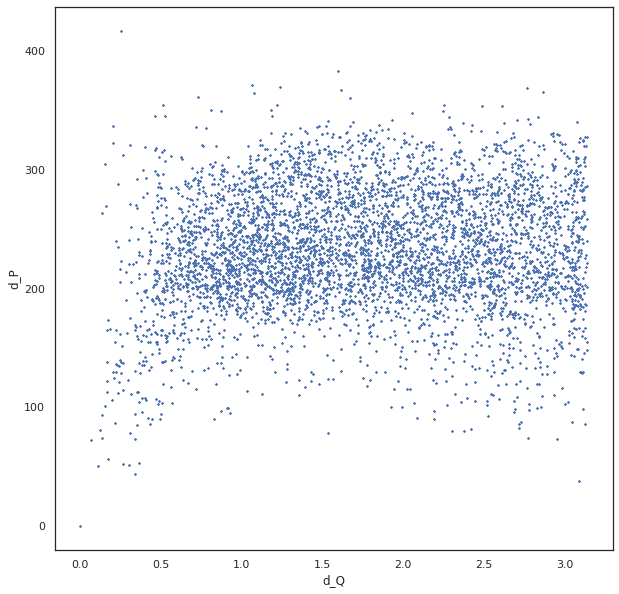

In [12]:
# Plot convergence.
plt.figure(figsize=(10,10))
plt.plot(d_q_list[0], d_p_list[0], marker="*", markersize=2, lw=0)
plt.xlabel('d_Q')
plt.ylabel('d_P');

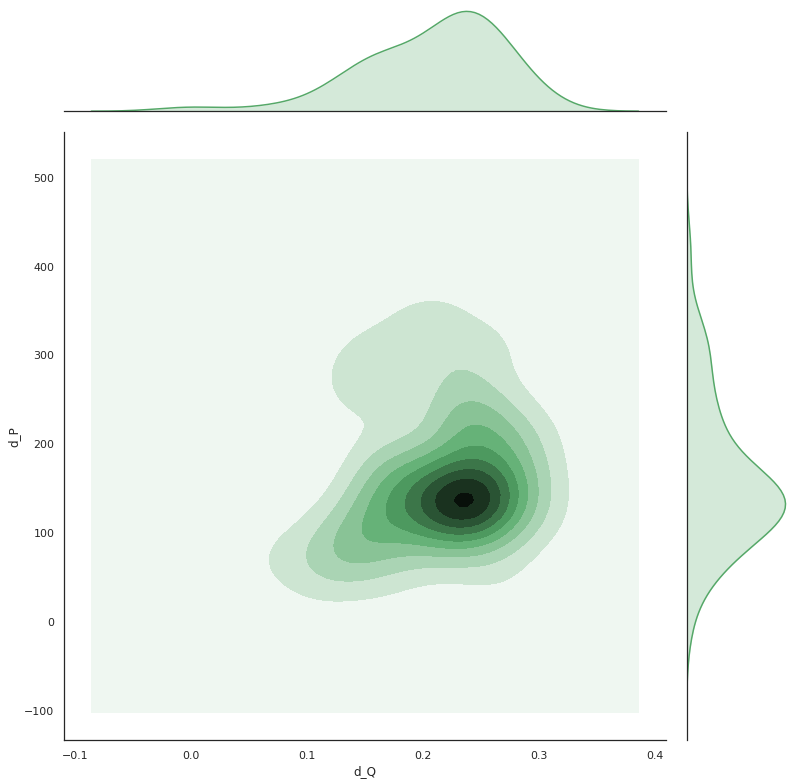

In [13]:
data = {"d_Q" : list(d_q_list[0][:5000].numpy()),
        "d_P" : [x[0] for x in list(d_p_list[0][:5000].numpy())]}
df = pd.DataFrame(data=data)
df = df[df.d_Q < 0.3]

sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)  # "reg", "kde"

In [14]:
batch_size=20000

d_q_list = []
d_p_list = []

# Sample some pairs.
idx1 = list(np.random.randint(0, n_samples, batch_size))
idx2 = list(np.random.randint(0, n_samples, batch_size))
a1 = [angles_true[i] for i in idx1]
a2 = [angles_true[i] for i in idx2]
q1 = quaternion.from_euler(a1)
q2 = quaternion.from_euler(a2)
q1 = quaternion.normalize(q1)
q2 = quaternion.normalize(q2)
distance_target_q = d_q(q1, q2)
d_q_list.append(distance_target_q)

# Compute distances between projections
p1 = [projections[i] for i in idx1]
p2 = [projections[i] for i in idx2]
distance_target_p = d_p(p1, p2)
d_p_list.append(distance_target_p)


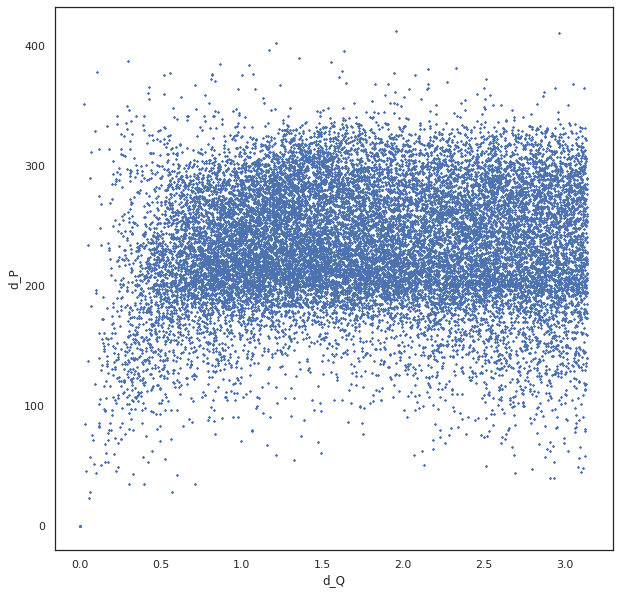

In [15]:
# Plot convergence.
plt.figure(figsize=(10,10))
plt.plot(d_q_list[0], d_p_list[0], marker="*", markersize=2, lw=0)
plt.xlabel('d_Q')
plt.ylabel('d_P');

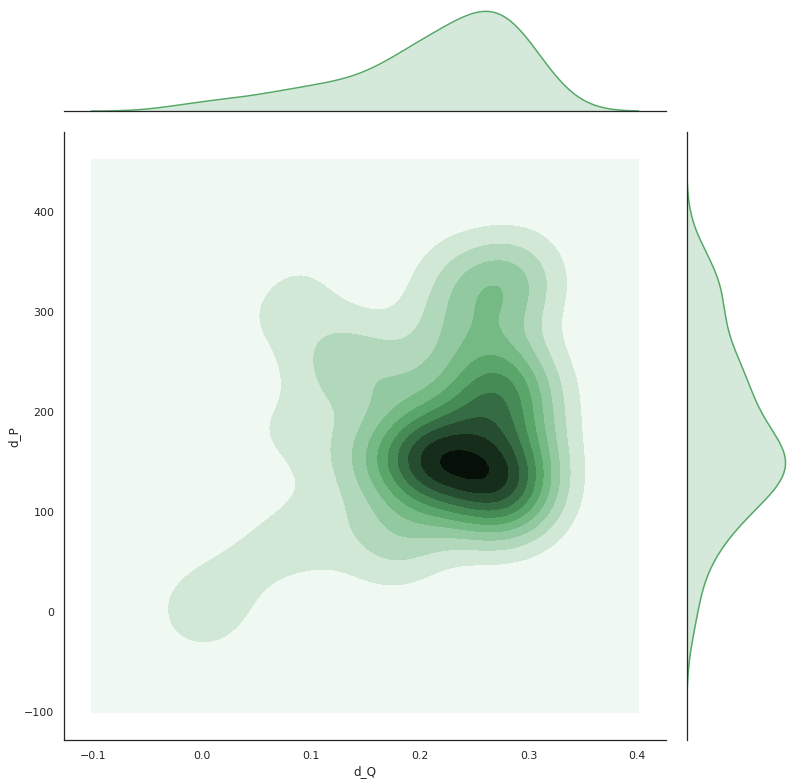

In [16]:
data = {"d_Q" : list(d_q_list[0][:5000].numpy()),
        "d_P" : [x[0] for x in list(d_p_list[0][:5000].numpy())]}
df = pd.DataFrame(data=data)
df = df[df.d_Q < 0.3]

sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)  # "reg", "kde"

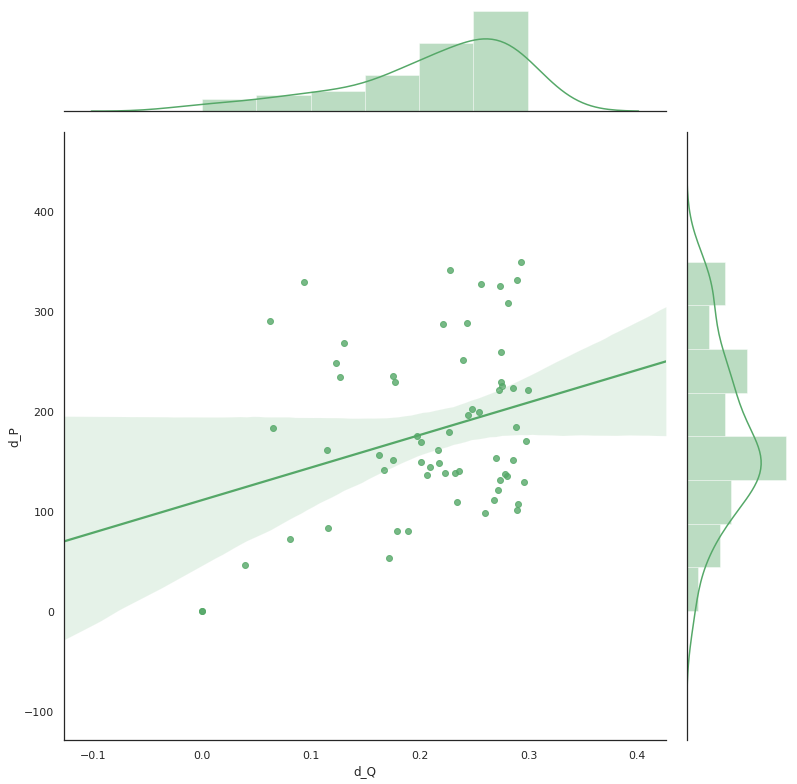

In [17]:
data = {"d_Q" : list(d_q_list[0][:5000].numpy()),
        "d_P" : [x[0] for x in list(d_p_list[0][:5000].numpy())]}
df = pd.DataFrame(data=data)
df = df[df.d_Q < 0.3]

sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11)  # "reg", "kde"

In [18]:
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(df["d_Q"],df["d_P"])
print(f"d_P/d_Q = {slope}, intercept = {intercept}")
# dP = slope*dQ + intercept
# => dQ = (dP-intercept)/slope

d_P/d_Q = 325.12337175584173, intercept = 110.91437729306804


#### Observing just the distances of one projection to all the other ones

In [11]:
d_q_list = []
d_p_list = []

# Sample some pairs.
idx1 = list([0]*5000)
idx2 = list(range(5000))
a1 = [angles_true[i] for i in idx1]
a2 = [angles_true[i] for i in idx2]
q1 = quaternion.from_euler(a1)
q2 = quaternion.from_euler(a2)
q1 = quaternion.normalize(q1)
q2 = quaternion.normalize(q2)
distance_target_q = d_q(q1, q2)
d_q_list.append(distance_target_q)

# Compute distances between projections
p1 = [projections[i] for i in idx1]
p2 = [projections[i] for i in idx2]
distance_target_p = d_p(p1, p2)
d_p_list.append(distance_target_p)


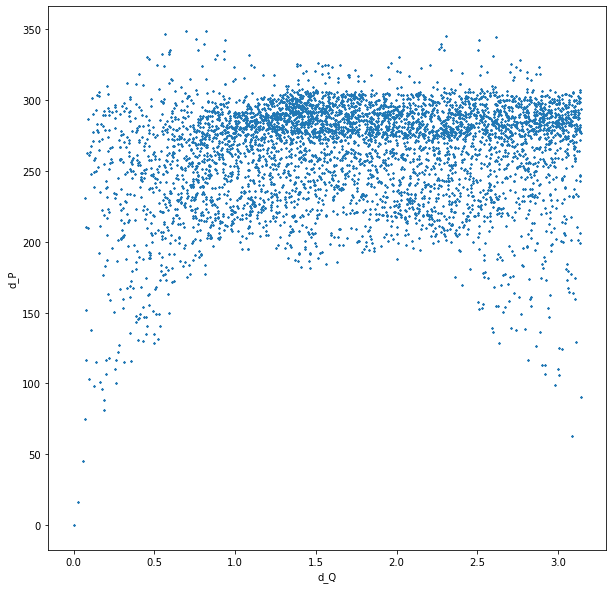

In [12]:
# Plot convergence.
plt.figure(figsize=(10,10))
plt.plot(d_q_list[0], d_p_list[0], marker="*", markersize=2, lw=0)
plt.xlabel('d_Q')
plt.ylabel('d_P');

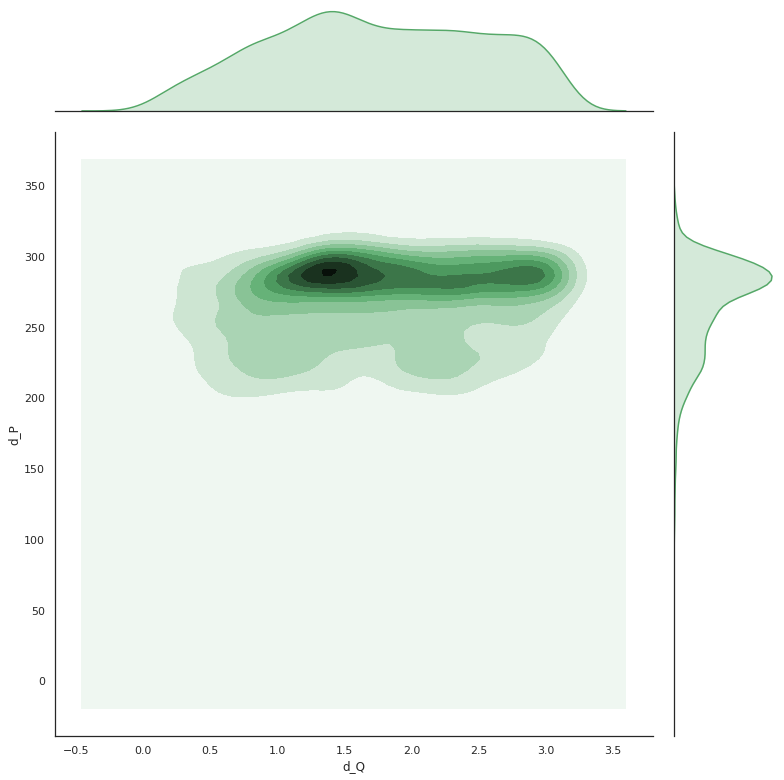

In [15]:
data = {"d_Q" : list(d_q_list[0][:5000].numpy()),
        "d_P" : [x[0] for x in list(d_p_list[0][:5000].numpy())]}
df = pd.DataFrame(data=data)
#df = df[df.d_Q < 0.3]

sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)  # "reg", "kde"

---

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{i,j} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [19]:
def loss(a1_predicted, a2_predicted, distance_target, normalize=None):
    q1 = quaternion.from_euler(a1_predicted)
    q2 = quaternion.from_euler(a2_predicted)

    q1 = quaternion.normalize(q1)
    q2 = quaternion.normalize(q2)
    
    distance = d_q(q1, q2)
    
    if normalize:
        #distance = normalize_quaternion_distance(distance)
        #distance_target = normalize(distance_target)
        distance_target = (distance_target-intercept)/slope
    
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [20]:
def gradient(a1_predicted, a2_predicted, distance_target, normalize=None):
    with tf.GradientTape() as tape:
        loss_value = loss(a1_predicted, a2_predicted, distance_target, normalize)
        gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

---

In [21]:
def loss_predicted_vs_true_angle(steps, batch_size, optimization=False):
    losses = np.empty(steps)
    time_start = time()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        idx2 = list(np.random.randint(0, n_samples, batch_size))
        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # Compute distances between true quaternions
        a1_true = [angles_true[i] for i in idx1]
        a2_true = [angles_true[i] for i in idx2]
        q1_true = quaternion.from_euler(a1_true)
        q2_true = quaternion.from_euler(a2_true)
        q1_true = quaternion.normalize(q1_true)
        q2_true = quaternion.normalize(q2_true)
        
        distance_target = d_q(q1_true, q2_true)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, normalize=False)
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target)
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean loss: {np.mean(losses)}")

## Optimization loop (projection-true & angles-predict)

### [Before] Prediction vs. True Angles

In [22]:
loss_predicted_vs_true_angle(steps=2000, batch_size=256)

step 200/2000 (2s): loss = 9.71e-01
step 400/2000 (4s): loss = 1.21e+00
step 600/2000 (6s): loss = 1.08e+00
step 800/2000 (9s): loss = 1.23e+00
step 1000/2000 (11s): loss = 1.18e+00
step 1200/2000 (13s): loss = 1.12e+00
step 1400/2000 (15s): loss = 1.23e+00
step 1600/2000 (17s): loss = 1.18e+00
step 1800/2000 (19s): loss = 1.12e+00
step 2000/2000 (21s): loss = 9.79e-01
Mean loss: 1.1110942272900481


step 200/2000 (217s): loss = 1.78e+00
step 400/2000 (439s): loss = 8.40e-01
step 600/2000 (653s): loss = 3.08e-01
step 800/2000 (859s): loss = 1.11e-01
step 1000/2000 (1070s): loss = 6.08e-02
step 1200/2000 (1280s): loss = 4.28e-02
step 1400/2000 (1494s): loss = 4.11e-02
step 1600/2000 (1699s): loss = 3.74e-02
step 1800/2000 (1901s): loss = 4.33e-02
step 2000/2000 (2099s): loss = 3.76e-02


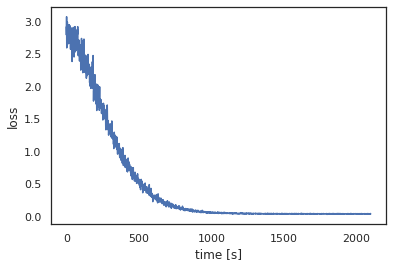

In [23]:
steps=2000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1 = list(np.random.randint(0, n_samples, batch_size))
    idx2 = list(np.random.randint(0, n_samples, batch_size))
    a1 = [angles_predicted[i] for i in idx1]
    a2 = [angles_predicted[i] for i in idx2]
    
    # Compute distances between projections
    p1 = [projections[i] for i in idx1]
    p2 = [projections[i] for i in idx2]
    
    distance_target = d_p(p1, p2)

    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(a1, a2, distance_target, normalize=True)
    optimizer.apply_gradients(zip(gradients, a1 + a2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

### [After] Prediction vs. True Angles

In [24]:
loss_predicted_vs_true_angle(steps=2000, batch_size=256)

step 200/2000 (2s): loss = 2.71e+00
step 400/2000 (4s): loss = 2.63e+00
step 600/2000 (6s): loss = 2.87e+00
step 800/2000 (9s): loss = 2.67e+00
step 1000/2000 (11s): loss = 2.69e+00
step 1200/2000 (13s): loss = 2.70e+00
step 1400/2000 (15s): loss = 2.66e+00
step 1600/2000 (16s): loss = 2.71e+00
step 1800/2000 (19s): loss = 2.58e+00
step 2000/2000 (21s): loss = 2.67e+00
Mean loss: 2.6364459362409196


---

### Predicted and true angle optimization, no projection (testing putposes)

In [22]:
loss_predicted_vs_true_angle(steps=2000, batch_size=256)

step 200/2000 (2s): loss = 1.01e+00
step 400/2000 (3s): loss = 9.64e-01
step 600/2000 (5s): loss = 1.06e+00
step 800/2000 (7s): loss = 9.84e-01
step 1000/2000 (9s): loss = 1.12e+00
step 1200/2000 (10s): loss = 1.03e+00
step 1400/2000 (12s): loss = 1.21e+00
step 1600/2000 (14s): loss = 1.13e+00
step 1800/2000 (15s): loss = 1.20e+00
step 2000/2000 (17s): loss = 1.04e+00
Mean loss: 1.1031962049314803


step 1000/10000 (75s): loss = 1.04e+00
step 2000/10000 (142s): loss = 9.28e-01
step 3000/10000 (209s): loss = 6.02e-01
step 4000/10000 (277s): loss = 2.87e-01
step 5000/10000 (344s): loss = 1.73e-01
step 6000/10000 (411s): loss = 1.29e-01
step 7000/10000 (477s): loss = 1.01e-01
step 8000/10000 (544s): loss = 8.31e-02
step 9000/10000 (611s): loss = 1.12e-01
step 10000/10000 (677s): loss = 8.10e-02


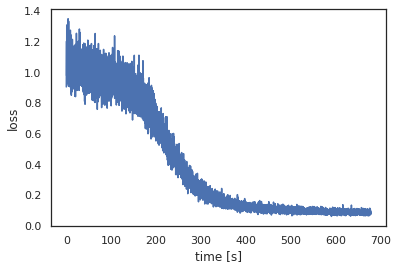

In [23]:
loss_predicted_vs_true_angle(steps=10000, batch_size=256, optimization=True)

In [24]:
loss_predicted_vs_true_angle(steps=2000, batch_size=256)

step 200/2000 (2s): loss = 7.17e-02
step 400/2000 (3s): loss = 8.95e-02
step 600/2000 (5s): loss = 8.14e-02
step 800/2000 (7s): loss = 8.29e-02
step 1000/2000 (9s): loss = 8.38e-02
step 1200/2000 (10s): loss = 9.28e-02
step 1400/2000 (12s): loss = 7.73e-02
step 1600/2000 (14s): loss = 6.35e-02
step 1800/2000 (16s): loss = 7.55e-02
step 2000/2000 (18s): loss = 7.72e-02
Mean loss: 0.08162729813965043
